## Outlier Detection with Local Outlier Factor (LOF) and LOF Ensemble

##### Why LOF?

I chose to use the Local Outlier Factor (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) because I remember its simplicity and the convenient implementation available in sklearn

This notebook covers:
- LOF detection
- LOF ensemble
- Simulate with feedback input
- Simple hybrid detection


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42)

### Dataset

This data (https://data.gov.au/dataset/ds-dga-0f3d60db-bd63-419e-9cd9-0a663f3abbc9/details) is made up of two elements:
- Responses to a survey from 25 Victorian householders about their energy consumption
- Energy consumption data (in Watt Hours (WH)) for each household in the sample from 1 April 2012 to 31 March 2014...

In [2]:
df = pd.read_csv('data/electricityconsumptionbenchmarkssurveydataaergovhack.csv')

In [3]:
df['respondent'].nunique()

25

In [4]:
df['respondent'].value_counts().nlargest(5)

17625    2190
3117     1460
18272    1382
6463     1382
1858     1356
Name: respondent, dtype: int64

In [5]:
respondent_id = 17625
type_of_interest = 'general'

# Get a time series dataset
df_ts = df[(df['respondent']==respondent_id) & (df['TYPE']==type_of_interest)].copy()

In [6]:
cols_hourly = [col for col in df_ts.columns if 'E_' in col]

In [7]:
# Get the daily total WHs
df_ts['E_WH'] = df_ts[list(cols_hourly)].sum(axis=1)

In [8]:
df_ts.head(5)

,respondent,OUTPUT_DATE,TYPE,E_0000_WH,E_0030_WH,E_0100_WH,E_0130_WH,E_0200_WH,E_0230_WH,E_0300_WH,...,E_1930_WH,E_2000_WH,E_2030_WH,E_2100_WH,E_2130_WH,E_2200_WH,E_2230_WH,E_2300_WH,E_2330_WH,E_WH
3462,17625,1/04/2012,general,68,50,92,20,86,60,44,...,232,202,304,458,404,248,284,410,594,5378
3465,17625,2/04/2012,general,390,374,106,146,150,108,130,...,2100,316,266,332,328,458,338,164,210,8744
3468,17625,3/04/2012,general,194,190,186,182,178,152,152,...,1366,566,296,434,842,546,466,364,344,11374
3471,17625,4/04/2012,general,252,90,88,86,94,96,94,...,604,652,602,598,590,642,678,214,110,9522
3474,17625,5/04/2012,general,92,94,72,70,86,90,88,...,386,1318,732,658,580,730,646,552,426,12370


In [9]:
df_ts['Date'] = df_ts['OUTPUT_DATE'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))

In [10]:
df_ts = df_ts[['Date','E_WH']]

In [11]:
df_ts.columns = ['Date','Value']

In [12]:
df_ts

,Date,Value
3462,2012-04-01,5378
3465,2012-04-02,8744
3468,2012-04-03,11374
3471,2012-04-04,9522
3474,2012-04-05,12370
...,...,...
5637,2014-03-27,4175
5640,2014-03-28,3831
5643,2014-03-29,7117
5646,2014-03-30,3910


In [13]:
data = df_ts.tail(100).copy()

# data = df_ts.copy()

In [14]:

# Calculate the moving average with a window of N days and standard deviation
n = 5
data['Moving_Average'] = data['Value'].rolling(window=n).mean()
data['STD'] = data['Value'].rolling(window=n).std()

### Outlier detection with LOF

In [15]:
k = 14
lof = LocalOutlierFactor(n_neighbors=k)


data['LOF_Outlier'] = lof.fit_predict(data[['Value']])

data['Final_Outlier'] = (data['LOF_Outlier']==-1).astype(int)


In [16]:
data.head(4)

,Date,Value,Moving_Average,STD,LOF_Outlier,Final_Outlier
5352,2013-12-22,5277,NaN,NaN,1,0
5355,2013-12-23,2375,NaN,NaN,1,0
5358,2013-12-24,2625,NaN,NaN,1,0
5361,2013-12-25,6964,NaN,NaN,1,0


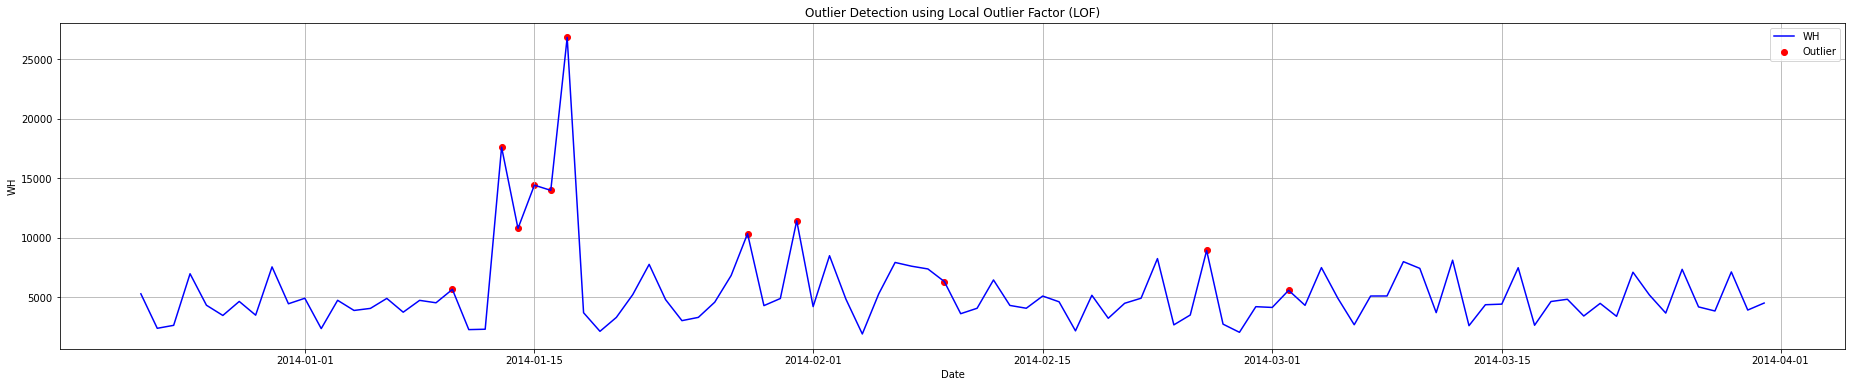

In [17]:
# Plot

plt.figure(figsize=(32, 6))
plt.plot(data['Date'], data['Value'], color='blue', label='WH')
outliers = data[data['Final_Outlier'] == 1]
plt.scatter(outliers['Date'], outliers['Value'], color='red', label='Outlier')
plt.xlabel('Date')
plt.ylabel('WH')
plt.title('Outlier Detection using Local Outlier Factor (LOF)')
plt.legend()
plt.grid(True)
plt.show()

### Ensemble multiple LOFs with different number of neighborss

In [18]:
# Ensemble multiple LOFs with different number of neighborss

neighbor_configs = [7, 14, 28, 35]
outlier_predictions = np.zeros((len(data), len(neighbor_configs)))

# Train multiple LOFs
for i, n_neighbors in enumerate(neighbor_configs):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    outlier_predictions[:, i] = lof.fit_predict(data[['Value']])

# Majority voting for outlier detection
votes = np.sum(outlier_predictions == -1, axis=1)

# Define threshold for being an outlier, e.g. more than half of the models
outlier_threshold = len(neighbor_configs) // 2
data['Outlier'] = (votes > outlier_threshold).astype(int)


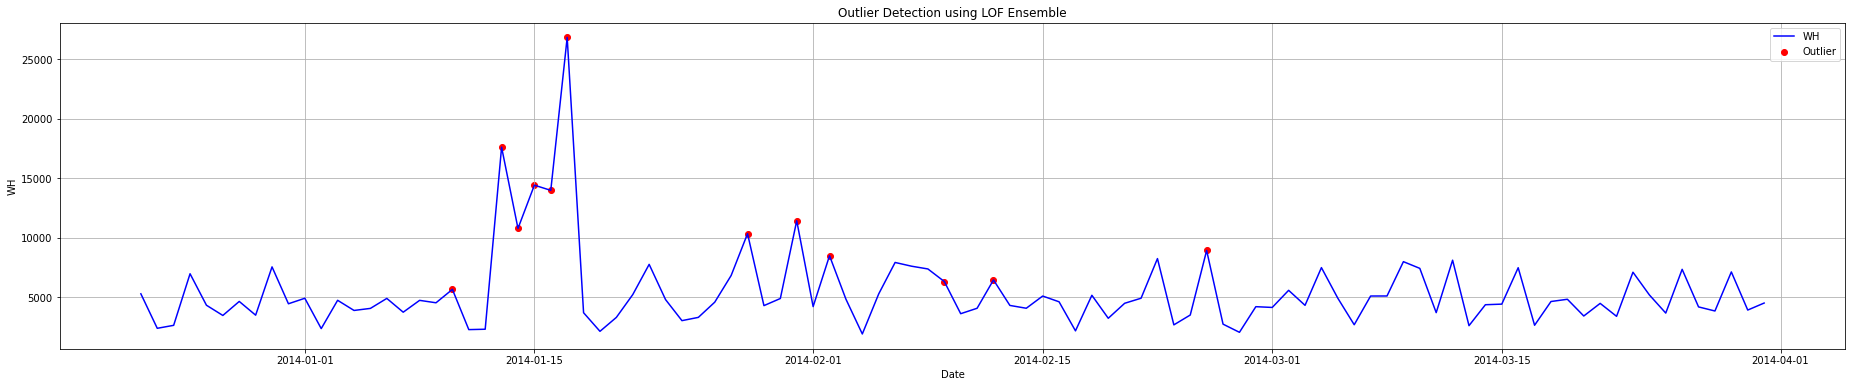

In [19]:

plt.figure(figsize=(32, 6))
plt.plot(data['Date'], data['Value'], color='blue', label='WH')
outliers = data[data['Outlier'] == 1]
plt.scatter(outliers['Date'], outliers['Value'], color='red', label='Outlier')
plt.xlabel('Date')
plt.ylabel('WH')
plt.title('Outlier Detection using LOF Ensemble')
plt.legend()
plt.grid(True)
plt.show()

### Ensemble multiple LOFs and utilse (random) feedback data

In [27]:
# Generate feedback with 90% empty values (adjusting probabilities)

feedback_choices = ['confirmed anomaly', 'not an anomaly', 'not sure', None]
probabilities = [0.025, 0.025, 0.025, 0.925]
data['Feedback'] = np.random.choice(feedback_choices, size=len(data), p=probabilities)

In [28]:
# Resampling based on feedback by oversampling confirmed anomalies
confirmed_anomalies = data[data['Feedback'] == 'confirmed anomaly']
data_new = pd.concat([data] + [confirmed_anomalies] * 5)  # Adjust multiplicity factor based on desired influence

In [29]:
data_new.shape, data.shape

((110, 9), (100, 9))

In [30]:

# Downsample or exclude non-anomalies
data_new = data_new[data_new['Feedback'] != 'not an anomaly']

# Ensure the data is sorted by date after resampling
data_new = data_new.sort_values('Date')

# LOF Ensemble
neighbor_configs = [7, 14, 28, 35]
outlier_predictions = np.zeros((len(data_new), len(neighbor_configs)))

for i, n_neighbors in enumerate(neighbor_configs):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    outlier_predictions[:, i] = lof.fit_predict(data_new[['Value']])

# Majority vote
votes = np.sum(outlier_predictions == -1, axis=1)
outlier_threshold = len(neighbor_configs) // 2
data_new['Outlier'] = (votes > outlier_threshold).astype(int)


In [31]:
data_new.shape, data.shape

((107, 9), (100, 9))

In [33]:
# LOF doesn't support instance weighting by default. Apparently, this naive downsampling is not very logical in our context, as it generates duplicated dates
# A more correct method would be modifying LOF to incorporate data point weighting in the nearest neighbor search stage. Here we are just pretending we are doing that

data_new[data_new['Feedback']=='confirmed anomaly']

,Date,Value,Moving_Average,STD,LOF_Outlier,Final_Outlier,Outlier,Feedback,MA_Outlier
5436,2014-01-19,2121,12208.8,9956.304370,0,0,0,confirmed anomaly,0
5436,2014-01-19,2121,12208.8,9956.304370,0,0,0,confirmed anomaly,0
5436,2014-01-19,2121,12208.8,9956.304370,0,0,0,confirmed anomaly,0
5436,2014-01-19,2121,12208.8,9956.304370,0,0,0,confirmed anomaly,0
5436,2014-01-19,2121,12208.8,9956.304370,0,0,0,confirmed anomaly,0
5436,2014-01-19,2121,12208.8,9956.304370,0,0,0,confirmed anomaly,0
5565,2014-03-03,4307,4047.8,1270.010315,0,0,0,confirmed anomaly,1
5565,2014-03-03,4307,4047.8,1270.010315,0,0,0,confirmed anomaly,1
5565,2014-03-03,4307,4047.8,1270.010315,0,0,0,confirmed anomaly,1
5565,2014-03-03,4307,4047.8,1270.010315,0,0,0,confirmed anomaly,1


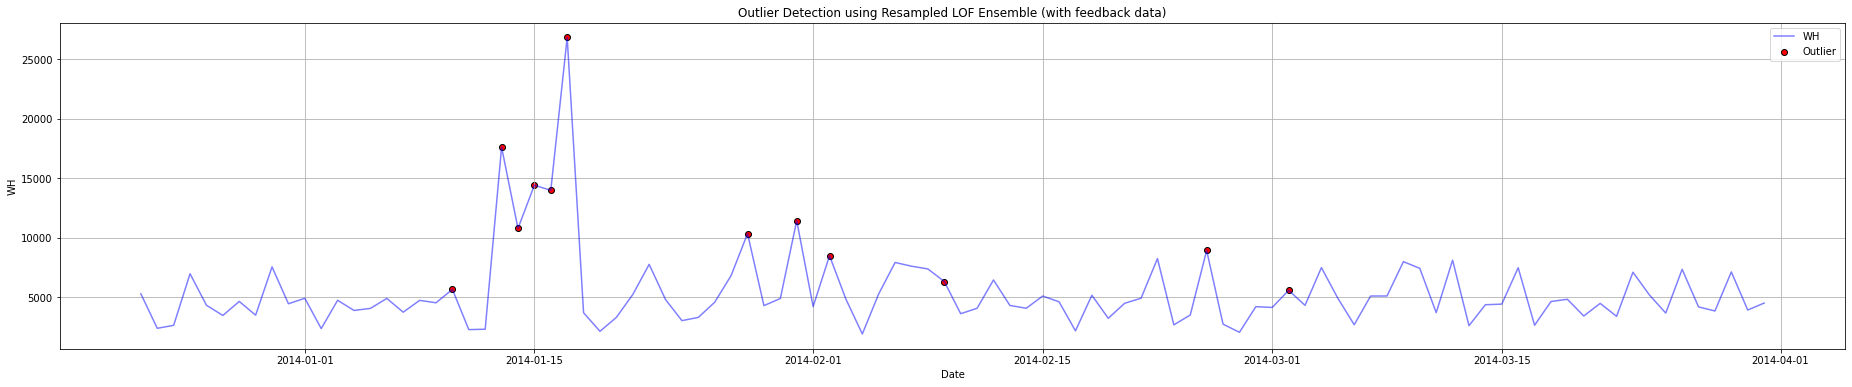

In [34]:

plt.figure(figsize=(32, 6))
plt.plot(data['Date'], data['Value'], color='blue', label='WH', alpha=0.5)

outliers = data_new[data_new['Outlier'] == 1]
plt.scatter(outliers['Date'], outliers['Value'], color='red', label='Outlier', edgecolors='k')
plt.xlabel('Date')
plt.ylabel('WH')
plt.title('Outlier Detection using Resampled LOF Ensemble (with feedback data)')
plt.legend()
plt.grid(True)
plt.show()

### Combing LOF Ensemble with a simple moving average-based method 

In [35]:

# LOF Ensemble
neighbor_configs = [7, 14, 28, 35]
outlier_predictions = np.zeros((len(data), len(neighbor_configs)))

for i, n_neighbors in enumerate(neighbor_configs):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    outlier_predictions[:, i] = lof.fit_predict(data[['Value']])

# Majority vote
votes = np.sum(outlier_predictions == -1, axis=1)
outlier_threshold = len(neighbor_configs) // 2
data['LOF_Outlier'] = (votes > outlier_threshold).astype(int)

# Mark outliers based on the moving average rule
data['MA_Outlier'] = (data['Value'] > data['Moving_Average']).astype(int)


# Combine LOF results with moving average-based detection
data['Final_Outlier'] = data['MA_Outlier'] & data['LOF_Outlier']


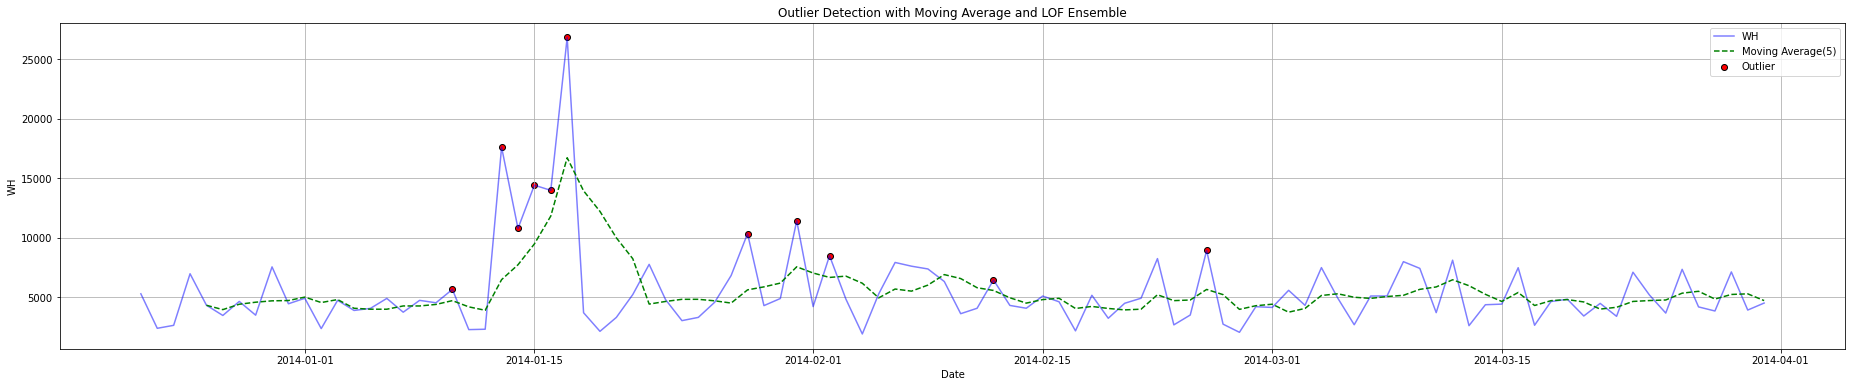

In [36]:
plt.figure(figsize=(32, 6))
plt.plot(data['Date'], data['Value'], color='blue', label='WH', alpha=0.5)
plt.plot(data['Date'], data['Moving_Average'], color='green', label=f'Moving Average({n})', linestyle='--')
outliers = data[data['Final_Outlier'] == 1]
plt.scatter(outliers['Date'], outliers['Value'], color='red', label='Outlier', edgecolors='k')
plt.xlabel('Date')
plt.ylabel('WH')
plt.title('Outlier Detection with Moving Average and LOF Ensemble')
plt.legend()
plt.grid(True)
plt.show()